In [1]:
## Generate Test Data

import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
#import warnings
#warnings.simplefilter('ignore', FutureWarning)
from scipy.integrate import simps


import numpy as np
from scipy import stats
import pandas as pd
from tqdm.notebook import tqdm
#from io import BytesIO
from twobitreader import TwoBitFile
import math
from scipy.signal import savgol_filter





/opt/anaconda3/lib/python3.7/site-packages/datascience/tables.py:17: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/opt/anaconda3/lib/python3.7/site-packages/datascience/util.py:10: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


# Generation of DeepCLIP Prediction Set

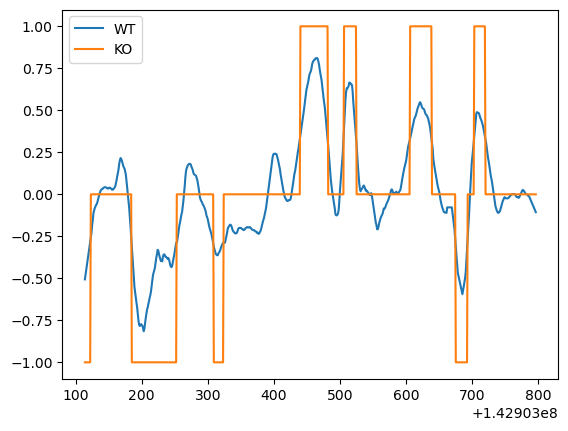

In [103]:
plt.plot(new_Deep_CLIP_reading_data.column(0), new_Deep_CLIP_reading_data.column(3),label="WT" )
plt.plot(new_Deep_CLIP_reading_data.column(0), new_Deep_CLIP_reading_data.column(4),label="KO" )
plt.legend()

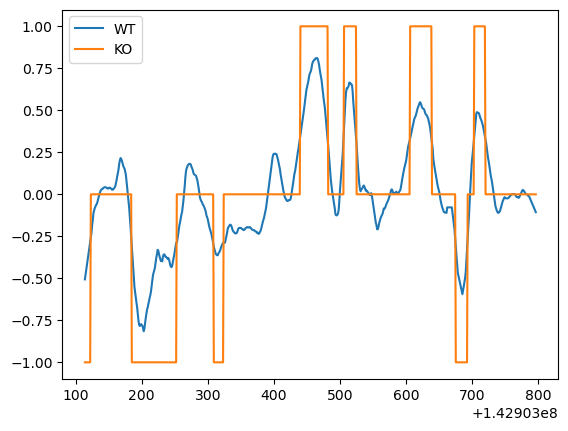

In [91]:

plt.plot(old_Deep_CLIP_reading_data.column(0), old_Deep_CLIP_reading_data.column(3),label="WT" )
plt.plot(old_Deep_CLIP_reading_data.column(0), old_Deep_CLIP_reading_data.column(4),label="KO" )
plt.legend()

In [2]:
utrs = Table.read_table("mm10_3pUTRs_curated_merged.csv")
gene_names_ALL = utrs.column("geneid")



def DEEP_CLIP(gene_names):
    from keras.models import Sequential, load_model
    from keras.layers import Dense, LSTM, TimeDistributed, Activation
    from keras import optimizers
    import pyBigWig
    #.notebook import tqdm
    
    pbar = tqdm.tqdm(total=len(gene_names))
    
    

    def get_depth_data(track_files,track_names,chrom,start,stop,strand,track_type):
        def view_region(track_file,strand,region):
            return subprocess.Popen(("samtools", "view",
                                     strand_to_flag[use_strand],
                                     "-b",track_file,
                                     region),stderr=subprocess.PIPE,stdout=subprocess.PIPE)
        mydepths = pd.DataFrame([0]*(stop-start+1),index=range(start,stop+1),columns=["depth"])
        depth_list = pd.DataFrame(0,index=range(start,stop),columns=track_names)
        strandinvert = {"+":"-","-":"+"}
        strand_to_flag = {"+":"-F 0x10",
            "-":"-f 0x10"}
        for n,track_file in enumerate(track_files):
            use_strand=strand
            region = chrom + ":" + str(start) + "-" + str(stop)
            if track_type[n] == "as":
                use_strand = strandinvert[strand]
            # Get sequences from a given region (in binary bam format still)
            ps =view_region(track_file,strand_to_flag[use_strand],region)
            sout,err = ps.communicate() # get stdout, stderr
            ## CHECK TO MAKE SURE THE REFERENCE GENOME CHROMOSOME IS FINE.
            if len(err)>0: # is there anytihn in stder?
                if b"specifies an unknown reference name" in err:
                    # SWITCH REFERENCE
                    temp_chrom = chrom.replace("chr","")
                    region = temp_chrom + ":" + str(start) + "-" + str(stop)
                    ps =view_region(track_file,strand_to_flag[use_strand],region)
                    sout,err = ps.communicate()
            if len(err)>0:
                raise NameError("Unknown samtools error. Ran: samtools view %s -b %s %s | samtools depth - " % (strand_to_flag[use_strand],track_file,region))
            # Run samtools depth on the sequences retrieved
            ps2 = subprocess.Popen(("samtools", "depth","-"),stdin=subprocess.PIPE,stdout=subprocess.PIPE)
            output,err = ps2.communicate(input=sout)
            sample_depths = pd.read_table(BytesIO(output),names=["chrom","depth"],index_col=1)
            if len(sample_depths.index)>0:
                mydepths.depth = sample_depths.depth
                depth_list[track_names[n]] = sample_depths.depth
                depth_list = depth_list.fillna(value=0)  
        return depth_list
    def ranges(nums):
        nums = sorted(set(nums))
        gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
        edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
        summ = list(zip(edges, edges))
        start = [summ[x][0] for x in np.arange(len(summ))]
        stop = [summ[x][1] for x in np.arange(len(summ))]

        return Table().with_columns("start", start, "stop", stop, "range", [i-j for i,j in zip(stop,start)])

    def range_generator(summary_tbl):

        cond_1 = ranges(summary_tbl.where("Greater Binding in Condition 1", are.equal_to(True)).column(0))
        cond_2 = ranges(summary_tbl.where("Greater Binding in Condition 2", are.equal_to(True)).column(0))
        return cond_1.where("range", are.above(3)), cond_2.where("range", are.above(3)), summary_tbl

    ### We are throwing away any regions called that have a lenth lower than 4 nucleotides

    def predictor_m_vals(read_data):
        data_comp = read_data.with_column("Adjusted_Fitted_M", savgol_filter(MA_normalization(read_data), 41,1))
        return (data_comp.column(3)- np.mean(data_comp.column(3))/(np.std(data_comp.column(3))))
    def MA_normalization(read_data):
        M = np.log(read_data.column(1) + .999999) - np.log(read_data.column(2) + .999999)
        A = (np.log(read_data.column(1) + .999999) + np.log(read_data.column(2) + .999999))
        slope, intercept, r_value, p_value, std_err =  stats.linregress(A,M)
        adjusted_M = M - ((slope*A)+intercept)

        return adjusted_M


    model = load_model('Adam-Loeb-50-1400.h5')


    def get_pred(arr):
        a = ((arr- np.mean(arr))/np.std(arr))
        b = ((arr- np.mean(arr))/np.std(arr))
        seq = [[x,y] for x,y in zip(a,b)]
        seq = np.array(seq)
        X, y = seq[:, 0], seq[:, 1]
        X = X.reshape((len(X), 1, 1))
        return X, y


    def auc_generator(condition, summ_tbl):
        depths = []
        startZ = condition.column("start")
        stopZ = condition.column("stop")
        for i in np.arange(condition.num_rows):
            start = startZ[i]
            stop = stopZ[i]
            depth = simps(summ_tbl.where(0, are.between(start, stop+1)).column("Adjusted_Fitted_M"))
            if depth <0:
                depth = -1*depth # We multiply by -1 because we don't care wether integrated area is positive or negative
                                # We only care for the intensity (magnitude) of the integral
            depths.append(depth)
        return np.asarray(depths)


    cond1_starts, cond1_stops, cond1_strands, cond1_chroms, cond1_geneIDs, cond1_depths = [], [], [], [], [], []
    cond2_starts, cond2_stops, cond2_strands, cond2_chroms, cond2_geneIDs, gene_runs, cond2_depths = [], [], [], [], [], [], []
    f1 = "bams/KOTh2_noMiRBase_DUPLICATE_RM.bam"
    f2 = "bams/WTTh2_noMiRBase_DUPLICATE_RM.bam"
    for gene_name in gene_names:
        pbar.update(1)
        unique_utrs = utrs.where("geneid",gene_name)
        chrom = unique_utrs["chrom"][0] 
        start = unique_utrs["start"][0]
        stop = unique_utrs["stop"][0]
        strand = unique_utrs["strands"][0]
        geneid = unique_utrs["geneid"][0]
        region = chrom + ":" + str(start) + "-" + str(stop)
        
        depths = get_depth_data(make_array(f1, f2),make_array(f1, f2),chrom,start,stop,strand,["s", "s"])
        f1_depths = depths[f1].tolist()
        f2_depths = depths[f2].tolist()

        reading_data = Table().with_columns("Unnamed: 0",depths.index.tolist(), f1,f1_depths, f2, f2_depths)

        
        if sum(reading_data.column(1)) > 0 and sum(reading_data.column(2)) > 0 and reading_data.num_rows >41:
            reading_data.column(2) - reading_data.column(1)
            difference = reading_data.column(2) - reading_data.column(1)
            if sum(difference  == difference[0]) != len(difference): #There cannot be a constant difference in read depth
                if sum(np.isnan(MA_normalization(reading_data))) != len(reading_data.column(1)):
                    predictor = predictor_m_vals(reading_data)
                    reading_data = reading_data.with_column("m_val", predictor )#.select(0,3)
                    vals = []
                    X,y = get_pred(reading_data.column("m_val"))
                    yhat = model.predict([X], verbose=0)

                    if sum(np.isnan(yhat))[0] != len(yhat):
                        # If we get an array of all NANs, ignore it.
                        yhat = savgol_filter([yhat[z][0] for z in np.arange(len(yhat))], 21,1)
                        for b in np.arange(len(yhat)):
                            val = yhat[b]
                            min_pos = np.argmin([abs(1.-val), abs(val), abs(-1-val)])
                            if min_pos ==0:
                                val = 1
                            if min_pos ==1:
                                val = 0
                            if min_pos ==2:
                                val = -1
                            vals.append(val)
                        reading_data = reading_data.with_columns("vals", vals)
                        ##PLOT DATA TEST
                        ##reading_data.plot(0,width=15, height=7)
                        reading_data = reading_data.with_column("Greater Binding in Condition 1",reading_data.column("vals")==1 )
                        reading_data = reading_data.with_column("Greater Binding in Condition 2",reading_data.column("vals")==-1 )
                        tbl = reading_data.relabeled("Unnamed: 0", "pos").relabeled("m_val", "Adjusted_Fitted_M").relabeled("vals", "lstm predictions")
                        cond1, cond2, summ_tbl = range_generator(tbl)
                        cond1 = cond1.with_column("strand", [strand for i in cond1.column(0)]).with_column("chrom", [chrom for i in cond1.column(0)]).with_column("geneid", [geneid for z in cond1.column(0)])
                        cond2 = cond2.with_column("strand", [strand for i in cond2.column(0)]).with_column("chrom", [chrom for i in cond2.column(0)]).with_column("geneid", [geneid for z in cond2.column(0)])

                        [cond1_geneIDs.append(i) for i in cond1.column("geneid")]
                        [cond1_chroms.append(i) for i in cond1.column("chrom")]
                        [cond1_starts.append(i) for i in [int(y) for y in cond1.column("start")]]
                        [cond1_stops.append(i) for i in [int(y) for y in cond1.column("stop")]]
                        [cond1_strands.append(i) for i in cond1.column("strand")]
                        [cond1_depths.append(i) for i in auc_generator(cond1, summ_tbl)]

                        [cond2_geneIDs.append(i) for i in cond2.column("geneid")]
                        [cond2_chroms.append(i) for i in cond2.column("chrom")]
                        [cond2_starts.append(i ) for i in [int(y) for y in cond2.column("start")]]
                        [cond2_stops.append(i) for i in [int(y) for y in cond2.column("stop")]]
                        [cond2_strands.append(i) for i in cond2.column("strand")]
                        [cond2_depths.append(i) for i in auc_generator(cond2, summ_tbl)]


    condition_1 = Table().with_columns("geneid", cond1_geneIDs, "chrom",cond1_chroms, "start",[int(y) for y in cond1_starts], "stop", [int(y) for y in cond1_stops],"strands",cond1_strands, "AUC Differential Binding",cond1_depths )
    condition_2 = Table().with_columns("geneid", cond2_geneIDs, "chrom",cond2_chroms, "start",[int(y) for y in cond2_starts], "stop", [int(y) for y in cond2_stops],"strands",cond2_strands, "AUC Differential Binding", cond2_depths)
    condition_1.to_csv("Output/" + "enrichedIN_cond1_" +cond1_geneIDs[0] + ".csv")
    condition_2.to_csv("Output/" + "enrichedIN_cond2_" +cond2_geneIDs[0] + ".csv")
    return "Done!"

In [3]:
import time
import random
import multiprocess
from multiprocess import Pool
import tqdm
import subprocess
from math import log
from io import BytesIO

start_time = time.time()
with Pool(processes=12,maxtasksperchild=20) as pool:
    pool.map(DEEP_CLIP, np.asarray(np.array_split(gene_names_ALL,12)))
stop_time = time.time()


pool.close()
pool.join()

#psutil.cpu_count(logical = True)

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
100%|██████████| 2263/2263 [23:00<00:00,  7.33it/s]   

In [4]:
print("--- %s seconds ---" % (stop_time - start_time))

--- 1387.9328467845917 seconds ---


In [5]:
import os
from scipy.stats import percentileofscore
from tqdm.notebook import tqdm


def sequence(reads):
    sequences = []
    genome = TwoBitFile("mm10.2bit")
    chroms = reads.column("chrom")
    starts = reads.column("start")
    stops = reads.column("stop")
    strands = reads.column("strand")
    for i in tqdm(np.arange(reads.num_rows)):
        chrom = chroms[i]
        start = int(starts[i])
        stop = int(stops[i])
        strand = strands[i]
        chromid = genome[chrom]
        sequence = chromid[start-1:stop].lower().replace("t", "u")
        if strand == "-":
            sequence = complement(sequence)
        sequences.append(sequence)
    reads = reads.with_column("RNA sequences", sequences)
    return reads
def complement(dna):
    complement = {'a': 'u', 'c': 'g', 'g': 'c', 'u': 'a' ,'n':'n'}
    return ''.join([complement[base] for base in dna[::-1]])


def q_C_list(cond_2):
    arr = cond_2.column("Differential Binding Enrichment(DBE)")

    # pre-sort array
    arr_sorted =  sorted(arr)

    # calculate percentiles using scipy func percentileofscore on each array element
    s = pd.Series(arr)
    percentiles = s.apply(lambda x: percentileofscore(arr_sorted, x))
    def quality_score(pct):
        if pct <= 25:
            return 1
        if pct <= 50:
            return 2
        if pct <=70:
            return 3
        if pct <= 80:
            return 4
        if pct <= 85:
            return 5 
        if pct <= 90:
            return 6 
        if pct <= 95:
            return 7
        if pct <= 97.5:
            return 8 
        if pct <= 99:
            return 9
        if pct <= 100:
            return 10
    cond_2 = cond_2.with_columns("percentile", percentiles, "QS", [quality_score(p) for p in percentiles])
    return cond_2

def concat_files(files):
    starts, stops, strands, chroms, geneIDs, depths = [], [], [], [], [], []
    for file in files:
        tbl = Table().read_table("Output/" + file)
        [starts.append(i) for i in tbl.column("start")]
        [stops.append(i) for i in tbl.column("stop")]
        [strands.append(i) for i in tbl.column("strands")]
        [chroms.append(i) for i in tbl.column("chrom")]
        [geneIDs.append(i) for i in tbl.column("geneid")]
        [depths.append(i) for i in tbl.column("AUC Differential Binding")]
    
        
    tbl = Table().with_columns("chrom", chroms,"start", starts, "stop", stops,"geneid",geneIDs,"Differential Binding Enrichment(DBE)",depths, "strand", strands )
    tbl = sequence(tbl)
    #tbl = q_C_list(tbl)
    return tbl


In [6]:
output = np.asarray(os.listdir("Output"))

cond1_files = output[["cond1" in i for i in output]]
cond2_files = output[["cond2" in i for i in output]]

cond2 =concat_files(cond2_files)
cond1 =concat_files(cond1_files)
cond2.to_csv("REDO_E_WT_vs_KO_W41.csv")
cond1.to_csv("REDO_E_KO_vs_WT_W41.csv") 

# Generation of dCLIP Prediction Set

dCLIP was run by the following command: perl bin/dCLIP.pl -f1 bams/KOTh2_noMiRBase.sam -f2 bams/WTTh2_noMiRBase.sam -step 1.

### Useless code:
from numpy import loadtxt
file = open("dCLIP Output/dCLIP_output.txt")

lines = (file.readlines())

idz = [i.split("\t")[0] for i in lines][1:]
chroms = [i.split("\t")[1] for i in lines][1:]
strands = [i.split("\t")[2] for i in lines][1:]
positions = [i.split("\t")[3] for i in lines][1:]
states = [i.split("\t")[4] for i in lines][1:]
probabilities = [i.split("\t")[5] for i in lines][1:]
differentials = [i.split("\t")[6] for i in lines][1:]

idz = [int(i) for i in idz]
positions = [int(i) for i in positions]
states = [int(i) for i in states]
probabilities = [float(i) for i in probabilities]
differentials = [float(i) for i in differentials]

ID = []
START = []
STOP = []


for indx in list(set(idz)):
    a

In [27]:
# 255,0,0 = RED = increased binding in condition 2 than 1 = Enrichment in WT relative to KO
# 0,0,255 = BLUE = increased binding in condition 1 than 2 = Enrichment in KO relative to WT

from numpy import loadtxt
file = open("dCLIP Output/dCLIP_summary_IN_3'UTRs.txt")
lines = (file.readlines())[1:]
chroms = np.asarray([i.split("\t")[0] for i in lines])
starts = np.asarray([i.split("\t")[1] for i in lines])
stops = np.asarray([i.split("\t")[2] for i in lines])
ID = [i.split("\t")[3] for i in lines]
dclip_DBE = np.asarray([i.split("\t")[4] for i in lines])
strands = np.asarray([i.split("\t")[5] for i in lines])
colors = [i.split("\t")[8].split("\n")[0] for i in lines]

EWT = '"255,0,0"' == np.asarray(colors)
EKO = '"0,0,255"' == np.asarray(colors)

E_WT = sequence(Table().with_columns("chrom", chroms[EWT], "start", starts[EWT], "stop", stops[EWT], "dCLIP DBE",dclip_DBE[EWT], "strand", strands[EWT]).where("chrom", are.not_equal_to("chrUn")))
E_KO = sequence(Table().with_columns("chrom", chroms[EKO], "start", starts[EKO], "stop", stops[EKO], "dCLIP DBE",dclip_DBE[EKO], "strand", strands[EKO]).where("chrom", are.not_equal_to("chrUn")))
E_WT.to_csv("dCLIP Output/EWT.csv")
E_KO.to_csv("dCLIP Output/EKO.csv")

# Figure 1

In [497]:
sum(new.column("count")), sum(old.column("old count"))

(42297, 44442)

In [8]:
old = Table().read_table("cond2_repeat.csv").group("geneid").relabeled("count", "old count")

new = DeepCLIP_WT.group("geneid")
new = new.with_column("geneid", [i.split("-")[0] for i in new.column("geneid")])

combo = new.join("geneid", old)#.column

NameError: name 'DeepCLIP_WT' is not defined

In [498]:
sum(combo.column("count"))

40669

In [502]:
old = Table().read_table("E_WT_vs_KO.csv")
old.with_column("truth", ["Icos" in i for i in old.column("geneid")]).where("truth", True)

chrom,start,stop,geneid,Differential Binding Enrichment(DBE),strand,RNA sequences,percentile,QS,truth
chr1,60998041,60998144,Icos-664994853,68.5191,+,auaucuccagcauuuuuuuacaaaaaaugccaaggguaugaaucuguaaagcacac ...,75.9661,4,True
chr1,60998993,60999051,Icos-664994853,27.9949,+,uagccuucuuuagaauaugaguuaguuggaaggauucugaaguguaaagagcauaugac,31.431,2,True
chr1,60999153,60999194,Icos-664994853,16.1804,+,cucacaaacuuuaaguaaaauauggcugcaucauaguuuuaa,9.68603,1,True
chr1,60999467,60999487,Icos-664994853,6.51321,+,augacuucuugaagaacaaaa,2.06768,1,True
chr1,60999849,60999893,Icos-664994853,19.6863,+,gacugcacucuugauaacuugacagucaccaauaucagaaaauua,15.0155,1,True
chr1,61000200,61000248,Icos-664994853,33.43,+,gggcggcucacauuuugguuugccaaguaacugccaguguuuguuuuca,40.087,2,True
chr10,78078649,78078750,Icosl-431709312,75.8708,+,cuccaggcugaugcaguagggggcacggacuccccgauggaacacaguaucugacc ...,80.2007,5,True
chr10,78078914,78078934,Icosl-431709312,7.1768,+,uucaaugaguguagagagaac,2.3309,1,True
chr10,78079249,78079345,Icosl-431709312,73.0307,+,acacacugccccccacccccugcuuauguaggcauugggaacccuucacagaccac ...,78.7701,4,True


In [11]:
DeepCLIP_WT.with_column("truth", ["Actb" in i for i in DeepCLIP_WT.column("geneid")]).where("truth", True)

geneid,chrom,start,stop,strand,AUC Differential Binding,RNA sequences,truth
Actb-283026161,chr5,142903114,142903122,-,3.15782,cacaaacag,True
Actb-283026161,chr5,142903185,142903252,-,34.5271,cccuuuuuuuuguccccccaacuugauguaugaaggcuuuggucucccugggaggg ...,True
Actb-283026161,chr5,142903309,142903323,-,4.69192,auuuuuuuaaaucuu,True
Actb-283026161,chr5,142903675,142903692,-,8.35494,aauuuuuuuuaaaguuuu,True


In [38]:
DeepCLIP_WT.num_rows

35715

In [39]:
DeepCLIP_WT = Table().read_table("REDO_E_WT_vs_KO.csv")
DeepCLIP_KO = Table().read_table("REDO_E_KO_vs_WT.csv")



dCLIP_WT = Table().read_table("dCLIP Output/EWT.csv")
dCLIP_KO = Table().read_table("dCLIP Output/EKO.csv")

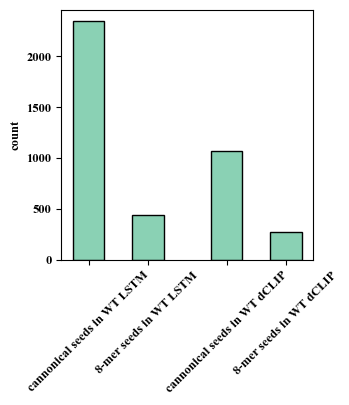

In [40]:
######################## 8-mer Motifs
miR23_c2 = sum([z.count("aaugugaa") for z in DeepCLIP_WT.column("RNA sequences")])
miR24_c2 = sum([z.count("cugagcca") for z in DeepCLIP_WT.column("RNA sequences")])
miR27_c2 = sum([z.count("acugugaa") for z in DeepCLIP_WT.column("RNA sequences")])

miR23_c1 = sum([z.count("aaugugaa") for z in DeepCLIP_KO.column("RNA sequences")])
miR24_c1 = sum([z.count("cugagcca") for z in DeepCLIP_KO.column("RNA sequences")])
miR27_c1 = sum([z.count("acugugaa") for z in DeepCLIP_KO.column("RNA sequences")])


miR23_d2 = sum([z.count("aaugugaa") for z in dCLIP_WT.column("RNA sequences")])
miR24_d2 = sum([z.count("cugagcca") for z in dCLIP_WT.column("RNA sequences")])
miR27_d2 = sum([z.count("acugugaa") for z in dCLIP_WT.column("RNA sequences")])

miR23_d1 = sum([z.count("aaugugaa") for z in dCLIP_KO.column("RNA sequences")])
miR24_d1 = sum([z.count("cugagcca") for z in dCLIP_KO.column("RNA sequences")])
miR27_d1 = sum([z.count("acugugaa") for z in dCLIP_KO.column("RNA sequences")])

cond_2_count_8 = (miR23_c2 +miR24_c2+miR27_c2)
cond_1_count_8 = (miR23_c1 + miR24_c1+miR24_c1)

d2_count_8 = (miR23_d2 + miR24_d2 + miR27_d2)
d1_count_8 = (miR23_d1 + miR24_d1 + miR27_d1)



######################## Cannonical Motifs
miR23_c2 = sum([z.count("auguga") for z in DeepCLIP_WT.column("RNA sequences")])
miR24_c2 = sum([z.count("ugagcc") for z in DeepCLIP_WT.column("RNA sequences")])
miR27_c2 = sum([z.count("cuguga") for z in DeepCLIP_WT.column("RNA sequences")])

miR23_c1 = sum([z.count("auguga") for z in DeepCLIP_KO.column("RNA sequences")])
miR24_c1 = sum([z.count("ugagcc") for z in DeepCLIP_KO.column("RNA sequences")])
miR27_c1 = sum([z.count("cuguga") for z in DeepCLIP_KO.column("RNA sequences")])


miR23_d2 = sum([z.count("auguga") for z in dCLIP_WT.column("RNA sequences")])
miR24_d2 = sum([z.count("ugagcc") for z in dCLIP_WT.column("RNA sequences")])
miR27_d2 = sum([z.count("cuguga") for z in dCLIP_WT.column("RNA sequences")])

miR23_d1 = sum([z.count("auguga") for z in dCLIP_KO.column("RNA sequences")])
miR24_d1 = sum([z.count("ugagcc") for z in dCLIP_KO.column("RNA sequences")])
miR27_d1 = sum([z.count("cuguga") for z in dCLIP_KO.column("RNA sequences")])


cond_2_count = (miR23_c2 +miR24_c2+miR27_c2)

cond_1_count = (miR23_c1 + miR24_c1+miR24_c1)

d2_count = (miR23_d2 + miR24_d2 + miR27_d2)
d1_count = (miR23_d1 + miR24_d1 + miR27_d1)



plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 9
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'




matplotlib.rc('font')

plt.figure(figsize=(3.25,3.25))
height = [cond_2_count,cond_2_count_8,d2_count,d2_count_8]
bars = ('cannonical seeds in WT LSTM','8-mer seeds in WT LSTM', 'cannonical seeds in WT dCLIP','8-mer seeds in WT dCLIP')
y_pos = np.asarray([1,2.5,4.5,6])
plt.bar(y_pos, height, color=["#8ad1b4","#8ad1b4","#8ad1b4","#8ad1b4"],edgecolor='black')
plt.xticks(y_pos, bars, rotation=45)
plt.ylabel("count")
plt.savefig("Figures/1.1.pdf")

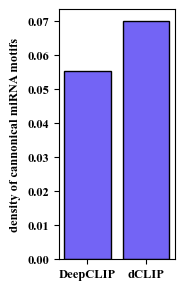

In [41]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 9
plt.rcParams["font.style"] = 'normal'




plt.figure(figsize=(1.5,3.25))
height = [cond_2_count/DeepCLIP_WT.num_rows,d2_count/dCLIP_WT.num_rows]
bars = ('DeepCLIP','dCLIP')
y_pos = [1.5,2.5]
plt.bar(y_pos, height, color=["#7364f5","#7364f5"],edgecolor='black')
plt.xticks(y_pos, bars, rotation=360)
plt.ylabel("density of cannonical miRNA motifs")
plt.savefig("Figures/1.2.pdf")

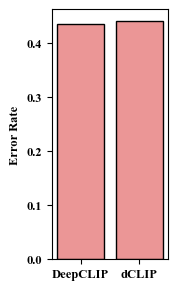

In [42]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 9
plt.rcParams["font.style"] = 'normal'
plt.rcParams["font.weight"] = 'normal'




matplotlib.rc('font')

plt.figure(figsize=(1.5,3.25))
height = [cond_1_count/cond_2_count,d1_count/d2_count]
bars = ('DeepCLIP','dCLIP')
y_pos = [1.5,2.5]
plt.bar(y_pos, height, color=["#eb9696","#eb9696"],edgecolor='black')
plt.xticks(y_pos, bars, rotation=360)
plt.ylabel("Error Rate")
plt.savefig("Figures/1.3.pdf")

# Figure 2

Predicted conserved targets were downloaded from TargetScan 7.2 and then saved to Predicted_Targets_mm10.csv.
The resulting analysis will attempt to quantify the overlap of TargetScan predicted miR-23,24,27 targets with that of the two algorithms.

In [43]:
targetscan = Table().read_table("BED_Intervene/Predicted_Targets_mm10.csv")
targetscan = targetscan.with_column("truth", [("miR-23" in i )+ ("miR-24" in i) + ("miR-27" in i) for i in targetscan.column("name")])
targetscan = targetscan.where("truth", are.above(0))
targetscan.to_csv("BED_Intervene/miR_23,24,27_Predicted_Targets_mm10.csv")

In [44]:
DeepCLIP_WT

chrom,start,stop,geneid,Differential Binding Enrichment(DBE),strand,RNA sequences,percentile,QS
chr2,91137474,91137496,Madd-934890474,11.6371,-,ugcaggcagagucuccuggcuuc,29.7704,2
chr2,91137995,91138023,Madd-934890474,23.9393,-,gugugugugugugugugguguguguggug,68.9387,3
chr2,91138138,91138227,Madd-934890474,77.8435,-,cugcuggacugagaugggaauguguguguguucucagcaaguuccuucccacgguc ...,98.9432,9
chr2,91138357,91138400,Madd-934890474,38.4425,-,cccacgagaucugcuacucuguguugugucucuucucguaugug,88.4034,6
chr2,91211456,91211510,Acp2-60822326,23.2105,+,augaagguuuugacugugagugcugguucugugccuuuuuucccuuccccauuuc,67.2175,3
chr2,91213831,91213869,Acp2-60822326,13.9849,+,cuggcugcccugguuuacauagucaggcuagccaggacu,38.7451,2
chr2,91275959,91275991,Arfgap2-704196241,14.6913,+,agccugugcaucgaguccuuguccucauccccu,41.3197,2
chr2,91276251,91276270,Arfgap2-704196241,7.45644,+,gacucgucacugcuguuccu,13.4005,1
chr2,91620460,91620506,Ckap5-856898222,57.2876,+,uuuuuuuuuguuuuguuuuaauggcucauuuguaaaauuguccuaau,96.4962,8
chr2,91620552,91620585,Ckap5-856898222,25.1054,+,ugaguugugagcucuucuucuguagcccugaagg,71.5819,4


# Figure 3

In [45]:
DeepCLIP_len = (DeepCLIP_WT.column("stop") -( DeepCLIP_WT.column("start")-1))
DeepCLIP_len = DeepCLIP_len[[i<300 for i in DeepCLIP_len]]
dCLIP_len = (dCLIP_WT.column("stop") -( dCLIP_WT.column("start")-1))
dCLIP_len = dCLIP_len[[i<300 for i in dCLIP_len]]



In [46]:
sum(dCLIP_len < 50)/len(dCLIP_len)

0.793835436382755

In [47]:
sum(DeepCLIP_len < 50)/len(DeepCLIP_len)

0.839988651677424

(0.0, 300.0)

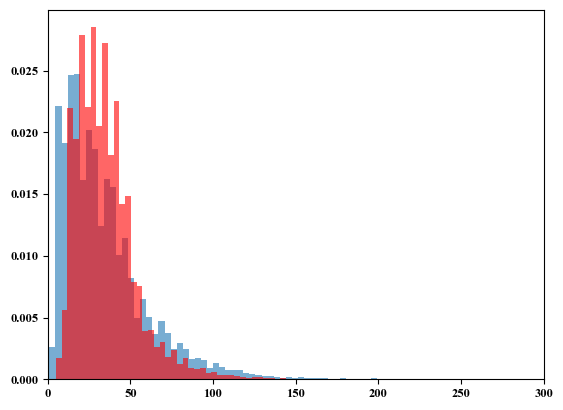

In [48]:
plt.hist(dCLIP_len, bins=75, density=True, alpha=0.6)
plt.hist(DeepCLIP_len, bins=75, density=True, color="red", alpha=0.6)


plt.xlim(0,300)

<Figure size 640x480 with 0 Axes>

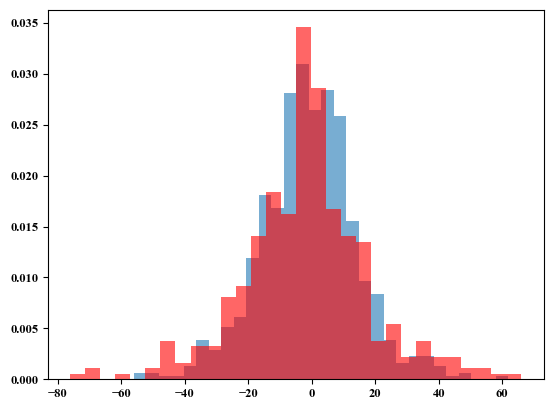

<Figure size 640x480 with 0 Axes>

In [49]:
plt.hist(motif_loci(DeepCLIP_WT), bins=30, density=True, alpha=0.6)
plt.hist(motif_loci(dCLIP_WT), bins=30, density=True, color="red", alpha=0.6)


#plt.xlim(0,300)
plt.figure()

In [57]:
np.std(dCLIP_len)

26.310999331998463

<Figure size 640x480 with 0 Axes>

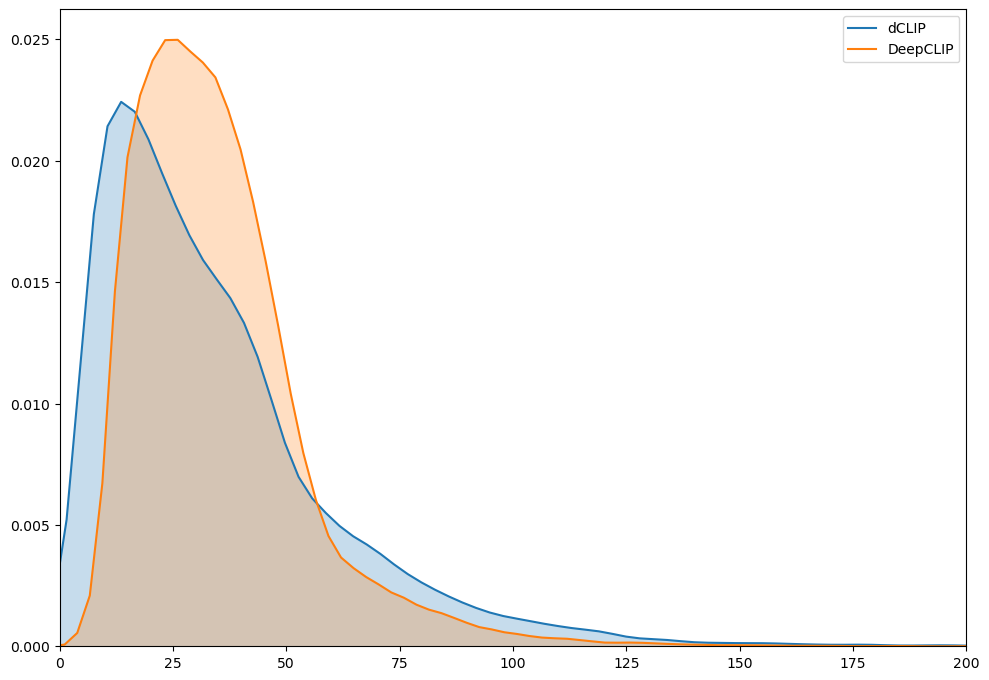

<Figure size 640x480 with 0 Axes>

In [50]:
import seaborn as sns 
from matplotlib import pyplot
plt.style.use('default') 


fig, ax = pyplot.subplots(figsize=(11.7, 8.27))
fontsize=60
sns.kdeplot(dCLIP_len, legend=True,shade=True,label='dCLIP')
sns.kdeplot(DeepCLIP_len, legend=True,shade=True,label='DeepCLIP')


plt.xlim(0, 200)
plt.figure()

In [51]:
DeepCLIP_WT.num_rows

42297

In [54]:
def motif_loci(tbl_input):
    tbl = tbl_input.with_column("motif locus", ["aaugugaa" in i for i in tbl_input.column("RNA sequences")]).where("motif locus", True)
    motif_loci = [i.find("aaugugaa") +3 for i in tbl.column("RNA sequences")]
    motif_loci = np.asarray(motif_loci) -  [int(len(i)/2) for i in tbl.column("RNA sequences")]
    return motif_loci

motif_loci

<function __main__.motif_loci(tbl_input)>

<Figure size 640x480 with 0 Axes>

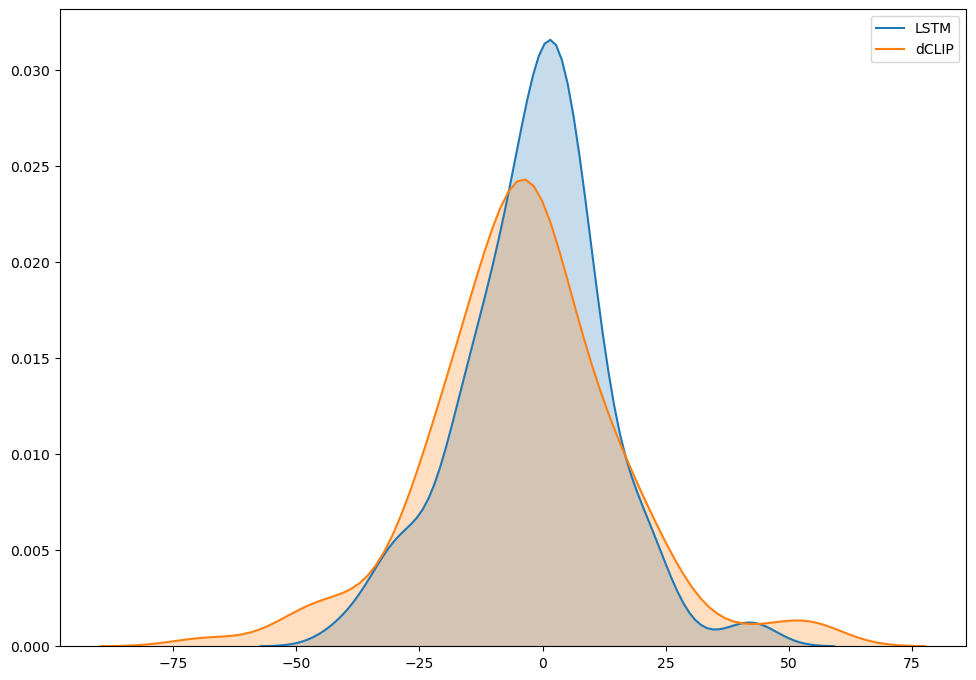

<Figure size 640x480 with 0 Axes>

In [55]:
import seaborn as sns #lstm_preds
from matplotlib import pyplot
plt.style.use('default') 
fig, ax = pyplot.subplots(figsize=(11.7, 8.27))

sns.kdeplot(motif_loci(DeepCLIP_WT), legend=True,shade=True,label='LSTM')
sns.kdeplot(motif_loci(dCLIP_WT), legend=True,shade=True,label='dCLIP')

plt.figure()

